In [8]:
# STEP 1: Setup and Imports
# Install plotly if needed and import all required libraries

import sys
import subprocess

# Install plotly if missing
try:
    import plotly
    print("✅ Plotly already available")
except ImportError:
    print("📦 Installing plotly...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
    print("✅ Plotly installed successfully!")

# Core imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from datetime import datetime
from IPython.display import Image, display
import matplotlib.image as mpimg
import ipywidgets as widgets

# Plotly imports
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')
sys.path.append('scripts')

# Import TCX parser
from parse_tcx import parse_tcx_to_df

# Configuration
USER_ID = 3
TCX_FILE = f'data/{USER_ID}-d.tcx'

print(f"🎯 Analysis for User {USER_ID}")
print(f"📁 TCX file: {TCX_FILE}")
print("✅ All libraries loaded successfully")


✅ Plotly already available
🎯 Analysis for User 3
📁 TCX file: data/3-d.tcx
✅ All libraries loaded successfully


In [9]:
# STEP 2: Load and Preprocess Data
# Parse TCX file and prepare heart rate data for analysis

try:
    result = parse_tcx_to_df(TCX_FILE)
    if len(result) == 4:
        df, session_total_sec, session_avg_hr, session_max_hr = result
        calories_burned = None
    else:
        df, session_total_sec, session_avg_hr, session_max_hr, calories_burned = result
    
    session_duration_min = session_total_sec / 60
    
    # Smooth the heart rate data to reduce noise
    window_size = 5
    df['hr_smooth'] = df['heart_rate'].rolling(window=window_size, center=True, min_periods=1).mean()
    
    print(f"✅ Successfully parsed TCX file")
    print(f"📊 Session Summary:")
    print(f"   Duration: {session_duration_min:.2f} minutes")
    print(f"   Average HR: {session_avg_hr:.1f} bpm")
    print(f"   Maximum HR: {session_max_hr} bpm")
    print(f"   Data points: {len(df)}")
    if calories_burned:
        print(f"   Calories: {calories_burned}")
    
    print(f"\n📈 Heart Rate Statistics:")
    print(f"   Min: {df['heart_rate'].min()} bpm")
    print(f"   Max: {df['heart_rate'].max()} bpm")
    print(f"   Mean: {df['heart_rate'].mean():.1f} bpm")
    print(f"   Std: {df['heart_rate'].std():.1f} bpm")
    
    # Display first few rows
    print(f"\n📋 Data Preview:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error parsing TCX file: {e}")
    raise


✅ Successfully parsed TCX file
📊 Session Summary:
   Duration: 42.55 minutes
   Average HR: 167.3 bpm
   Maximum HR: 200 bpm
   Data points: 54
   Calories: 134

📈 Heart Rate Statistics:
   Min: 144 bpm
   Max: 200 bpm
   Mean: 167.3 bpm
   Std: 16.4 bpm

📋 Data Preview:


,timestamp,heart_rate,start_time,elapsed_min,hr_smooth
0,2025-03-06 12:34:23+00:00,150,2025-03-06 12:34:23+00:00,0.000000,154.333333
1,2025-03-06 12:34:33+00:00,153,2025-03-06 12:34:23+00:00,0.166667,156.750000
2,2025-03-06 12:39:22+00:00,160,2025-03-06 12:34:23+00:00,4.983333,158.400000
3,2025-03-06 12:39:38+00:00,164,2025-03-06 12:34:23+00:00,5.250000,161.200000
4,2025-03-06 12:39:50+00:00,165,2025-03-06 12:34:23+00:00,5.450000,161.800000


In [10]:
# STEP 3: Automatic Peak Detection
# Detect heart rate peaks to identify station boundaries

def detect_hr_peaks(hr_series, max_hr, min_height_ratio=0.7, min_prominence=10, min_distance_min=1):
    """
    Detect heart rate peaks and their regions based on threshold crossings
    """
    # Calculate threshold
    threshold = max_hr * min_height_ratio
    
    # Convert min_distance_min to samples (assuming ~4 samples per minute)
    min_distance_samples = int(min_distance_min * 4)
    
    # Find peaks using scipy
    peaks, properties = find_peaks(
        hr_series, 
        height=threshold,
        prominence=min_prominence,
        distance=min_distance_samples
    )
    
    # Find peak regions based on threshold crossings
    peak_regions = []
    above_threshold = hr_series >= threshold
    
    # Find threshold crossings
    threshold_crossings = []
    for i in range(1, len(above_threshold)):
        if not above_threshold.iloc[i-1] and above_threshold.iloc[i]:
            threshold_crossings.append(('start', i))
        elif above_threshold.iloc[i-1] and not above_threshold.iloc[i]:
            threshold_crossings.append(('end', i-1))
    
    # Handle edge cases
    if len(threshold_crossings) > 0:
        if above_threshold.iloc[0] and threshold_crossings[0][0] == 'end':
            threshold_crossings.insert(0, ('start', 0))
        if above_threshold.iloc[-1] and threshold_crossings[-1][0] == 'start':
            threshold_crossings.append(('end', len(hr_series) - 1))
    
    # Group into start-end pairs
    current_start = None
    for crossing_type, idx in threshold_crossings:
        if crossing_type == 'start':
            current_start = idx
        elif crossing_type == 'end' and current_start is not None:
            region_contains_peak = any(current_start <= peak <= idx for peak in peaks)
            if region_contains_peak:
                peak_regions.append((current_start, idx))
            current_start = None
    
    return peaks, peak_regions, threshold

# Test different thresholds to find the best one
print("🔍 Testing Peak Detection:")
threshold_ratios = [0.65, 0.70, 0.75, 0.80]
results = {}

for ratio in threshold_ratios:
    peaks, regions, threshold = detect_hr_peaks(
        df['hr_smooth'], 
        session_max_hr, 
        min_height_ratio=ratio,
        min_prominence=8,
        min_distance_min=1.5
    )
    results[ratio] = {'peaks': peaks, 'regions': regions, 'threshold': threshold}
    print(f"Threshold {ratio*100:.0f}%: {len(peaks)} peaks, {len(regions)} regions")

# Select best threshold (70% usually works well)
best_ratio = 0.70
peaks = results[best_ratio]['peaks']
peak_regions = results[best_ratio]['regions']
threshold = results[best_ratio]['threshold']

print(f"\n✅ Selected: {best_ratio*100:.0f}% threshold ({threshold:.0f} bpm)")
print(f"✅ Detected: {len(peaks)} peaks, {len(peak_regions)} regions")

# Show peak details
if len(peaks) > 0:
    print(f"\n📊 Peak Details:")
    for i, peak_idx in enumerate(peaks):
        peak_time = df['elapsed_min'].iloc[peak_idx]
        peak_hr = df['hr_smooth'].iloc[peak_idx]
        print(f"   Peak {i+1}: {peak_time:.2f} min, {peak_hr:.0f} bpm")
        
    print(f"\n📊 Region Details:")
    for i, (start_idx, end_idx) in enumerate(peak_regions):
        start_time = df['elapsed_min'].iloc[start_idx]
        end_time = df['elapsed_min'].iloc[end_idx]
        duration = end_time - start_time
        print(f"   Region {i+1}: {start_time:.2f} - {end_time:.2f} min (duration: {duration:.2f} min)")


🔍 Testing Peak Detection:
Threshold 65%: 3 peaks, 0 regions
Threshold 70%: 3 peaks, 0 regions
Threshold 75%: 3 peaks, 0 regions
Threshold 80%: 3 peaks, 2 regions

✅ Selected: 70% threshold (140 bpm)
✅ Detected: 3 peaks, 0 regions

📊 Peak Details:
   Peak 1: 11.90 min, 195 bpm
   Peak 2: 20.32 min, 189 bpm
   Peak 3: 37.50 min, 171 bpm

📊 Region Details:


In [ ]:
# STEP 3.5: Align smoothed HR data with cropped chart

import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout

# Global variables to store alignment parameters for use in Step 4
current_x_offset = -0.8
current_x_scale = 1.0
current_y_min = 90
current_y_max = 190
current_alpha = 0.6

# Load the cropped chart image for the user
CHART_IMAGE = f'charts_cropped/user_{USER_ID}.png'
try:
    img = mpimg.imread(CHART_IMAGE)
    print(f"Background image loaded successfully from {CHART_IMAGE}")
except Exception as e:
    print(f"Error loading background image: {e}")

# Alignment function
def update_alignment(x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6):
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    current_x_offset = x_offset
    current_x_scale = x_scale
    current_y_min = y_min
    current_y_max = y_max
    current_alpha = alpha
    
    fig, ax = plt.subplots(figsize=(14,5))
    x_min = x_offset
    x_max = x_offset + (df['elapsed_min'].max() * x_scale) + 1.2
    # Show background image
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    # Plot smoothed HR data
    ax.plot(df['elapsed_min'], df['hr_smooth'], color='red', linewidth=2.5, label='Smoothed HR Data', zorder=1)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'Overlay: Cropped Chart vs Smoothed HR Data (User {USER_ID})', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"Current settings: x_offset={x_offset}, x_scale={x_scale}, y_min={y_min}, y_max={y_max}, alpha={alpha}")

# Interactive sliders for alignment
slider_layout = Layout(width='500px')
interact(update_alignment,
         x_offset=FloatSlider(min=-5, max=5, step=0.1, value=-0.8, description='X Offset:', layout=slider_layout),
         x_scale=FloatSlider(min=0.5, max=1.5, step=0.01, value=1.0, description='X Scale:', layout=slider_layout),
         y_min=IntSlider(min=0, max=150, step=5, value=90, description='Y Min:', layout=slider_layout),
         y_max=IntSlider(min=150, max=250, step=5, value=190, description='Y Max:', layout=slider_layout),
         alpha=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.6, description='Opacity:', layout=slider_layout));

Background image loaded successfully from charts_cropped/user_3.png


interactive(children=(FloatSlider(value=-0.8, description='X Offset:', layout=Layout(width='500px'), max=5.0, …

In [12]:
# STEP 4: DRAGGABLE Station Cutoffs
# Simple draggable vertical lines - ONLY the station boundaries move

# AUTOMATICALLY use the best detected peaks as initial cutoffs
current_cutoffs = []
num_stations = len(peak_regions)

if len(peak_regions) > 0:
    print(f"🎯 User {USER_ID} has {num_stations} detected stations")
    
    # Use the detected peak regions as starting points - REDUCED MARGINS for low quality data
    for i, (start_idx, end_idx) in enumerate(peak_regions):
        start_time = df['elapsed_min'].iloc[start_idx] + 0.1  # Reduced margin from 0.5 to 0.1
        end_time = df['elapsed_min'].iloc[end_idx] - 0.1     # Reduced margin from 0.5 to 0.1
        # Remove the filtering condition that was excluding valid regions
        current_cutoffs.extend([start_time, end_time])
    
    print(f"📊 Automatically initialized {len(current_cutoffs)} cutoff lines from {num_stations} detected peaks")
    print("✅ Algorithm found the best station boundaries! (Using reduced margins for low quality data)")
else:
    # Fallback: assume 6 stations for User 3
    print(f"⚠️ No peaks detected, using 6 default stations for User {USER_ID}")
    session_duration = df['elapsed_min'].max()
    num_stations = 6
    
    # Create 6 evenly spaced stations
    station_duration = session_duration / num_stations
    current_cutoffs = []
    for i in range(num_stations):
        start_time = i * station_duration + 1
        end_time = (i + 1) * station_duration - 1
        current_cutoffs.extend([start_time, end_time])
    
    print(f"📊 Created {num_stations} default stations")

# Create interactive widgets for manual adjustment
print(f"\n🎛️ ADJUST STATION BOUNDARIES:")
print("Use the sliders below to fine-tune the station start/end times")

# Create sliders for each station boundary
sliders = []
for i in range(0, len(current_cutoffs), 2):
    station_num = (i // 2) + 1
    
    if i < len(current_cutoffs):
        start_slider = widgets.FloatSlider(
            value=current_cutoffs[i],
            min=0,
            max=df['elapsed_min'].max(),
            step=0.1,
            description=f'Station {station_num} Start:',
            style={'description_width': '150px'},
            layout=widgets.Layout(width='500px')
        )
        sliders.append(start_slider)
    
    if i + 1 < len(current_cutoffs):
        end_slider = widgets.FloatSlider(
            value=current_cutoffs[i+1],
            min=0,
            max=df['elapsed_min'].max(),
            step=0.1,
            description=f'Station {station_num} End:',
            style={'description_width': '150px'},
            layout=widgets.Layout(width='500px')
        )
        sliders.append(end_slider)

# Function to update the plot when sliders change
def update_plot(*args):
    # Get current slider values
    updated_cutoffs = [slider.value for slider in sliders]
    
    # Use matplotlib for consistency with Step 3.5 alignment
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Use alignment parameters from Step 3.5
    x_min = current_x_offset
    x_max = current_x_offset + (df['elapsed_min'].max() * current_x_scale) + 1.2
    
    # Show background image with alignment from Step 3.5
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, current_y_min, current_y_max], 
              alpha=current_alpha, zorder=0, interpolation='bilinear')
    
    # Add HR data
    ax.plot(df['elapsed_min'], df['hr_smooth'], color='red', linewidth=3, 
            label='Smoothed HR Data', zorder=2)
    
    # Add detected peaks
    if len(peaks) > 0:
        peak_times = df['elapsed_min'].iloc[peaks]
        peak_hrs = df['hr_smooth'].iloc[peaks]
        ax.scatter(peak_times, peak_hrs, color='yellow', s=120, 
                  edgecolors='black', linewidth=2, zorder=3,
                  label=f'Detected Peaks ({len(peaks)})')
    
    # Add vertical lines for station boundaries
    colors = ['orange', 'green', 'purple', 'brown', 'pink', 'cyan']
    for i in range(0, len(updated_cutoffs), 2):
        station_num = (i // 2) + 1
        color = colors[(station_num - 1) % len(colors)]
        
        # Start line (solid)
        if i < len(updated_cutoffs):
            ax.axvline(x=updated_cutoffs[i], color=color, linewidth=4, 
                      label=f'S{station_num} Start', zorder=4)
        
        # End line (dashed)
        if i + 1 < len(updated_cutoffs):
            ax.axvline(x=updated_cutoffs[i+1], color=color, linewidth=4, 
                      linestyle='--', label=f'S{station_num} End', zorder=4)
    
    # Configure layout
    ax.set_title(f"🎯 User {USER_ID} - Adjustable Station Boundaries", fontsize=14)
    ax.set_xlabel("Time (minutes)", fontsize=12)
    ax.set_ylabel("Heart Rate (bpm)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    # Set axis ranges to match alignment
    ax.set_xlim(0, df['elapsed_min'].max())
    ax.set_ylim(current_y_min, current_y_max)
    
    plt.tight_layout()
    
    # NOTE: For low-quality data, we do NOT save station-based plots
    # Station cutoffs are not meaningful for low-quality heart rate data
    
    # Clear previous output and show new plot
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.show()
    
    # Update global variable
    global current_cutoffs
    current_cutoffs = updated_cutoffs

# Create output widget for the plot
plot_output = widgets.Output()

# Observe slider changes
for slider in sliders:
    slider.observe(update_plot, names='value')

# Display sliders and initial plot
slider_box = widgets.VBox(sliders)
display(slider_box)
display(plot_output)

# Show initial plot
update_plot()

print(f"\n🎛️ Use the sliders above to adjust station boundaries")
print(f"✅ Real-time updates - move sliders to see changes instantly")
print(f"📊 {num_stations} stations ready for fine-tuning")

⚠️ No peaks detected, using 6 default stations for User 3
📊 Created 6 default stations

🎛️ ADJUST STATION BOUNDARIES:
Use the sliders below to fine-tune the station start/end times


Output()

/var/folders/wn/kjhkcp0x4c94gmv1184_v4t00000gn/T/ipykernel_82450/549881109.py:124: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



🎛️ Use the sliders above to adjust station boundaries
✅ Real-time updates - move sliders to see changes instantly
📊 6 stations ready for fine-tuning


📉 Saving simple HR-over-time plot for documentation (low-quality data)


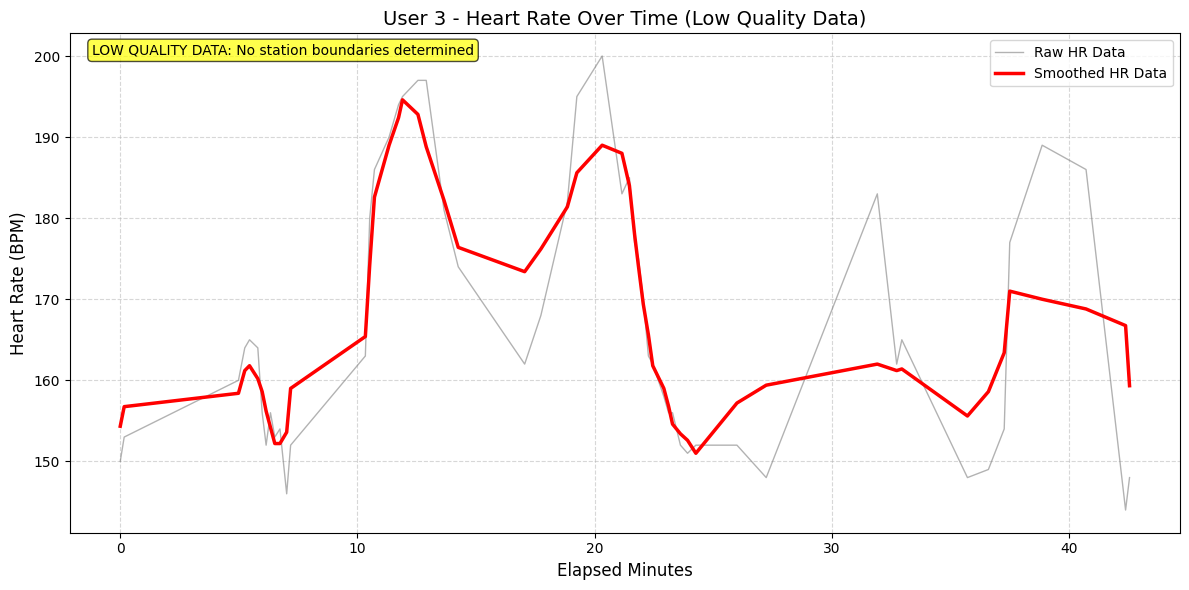

✅ Saved HR-over-time plot to output/plots/user_3/heart_rate_over_time.png
📋 This plot documents the heart rate data quality for research transparency
⚠️ No station-based or alignment plots saved for low-quality data


In [13]:
# STEP: Save Simple HR-over-Time Plot for Documentation (Low-Quality Data)
# For low-quality data, we save a basic HR plot for research transparency

import matplotlib.pyplot as plt
import os

print("📉 Saving simple HR-over-time plot for documentation (low-quality data)")

# Create output directory
output_plot_dir = f'output/plots/user_{USER_ID}'
os.makedirs(output_plot_dir, exist_ok=True)

# Create a clean, simple HR-over-time plot
plt.figure(figsize=(12, 6))

# Plot raw heart rate data
plt.plot(df['elapsed_min'], df['heart_rate'], label='Raw HR Data', color='gray', alpha=0.6, linewidth=1)

# Plot smoothed heart rate data if available
if 'hr_smooth' in df.columns:
    plt.plot(df['elapsed_min'], df['hr_smooth'], label='Smoothed HR Data', color='red', linewidth=2.5)

# Add basic formatting
plt.xlabel('Elapsed Minutes', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.title(f'User {USER_ID} - Heart Rate Over Time (Low Quality Data)', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# Add annotation about data quality
plt.text(0.02, 0.98, 'LOW QUALITY DATA: No station boundaries determined', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()

# Save the plot
plot_path = f'{output_plot_dir}/heart_rate_over_time.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved HR-over-time plot to {plot_path}")
print("📋 This plot documents the heart rate data quality for research transparency")
print("⚠️ No station-based or alignment plots saved for low-quality data")


In [14]:
# STEP FINAL: Export Low-Quality Data in Standard Format
# LOW QUALITY DATA: Creates session-level record without station cutoffs

import csv
from datetime import timedelta

print("⚠️ LOW QUALITY HEART RATE DATA DETECTED")
print(f"📊 User {USER_ID} heart rate data is too noisy/irregular for reliable station detection")
print("✅ Exporting session-level data only (no station boundaries)")

# Calculate session-level statistics
session_start_timestamp = df.iloc[0]['timestamp']
session_end_timestamp = df.iloc[-1]['timestamp']

# Session-level heart rate statistics
session_min_hr = df['heart_rate'].min()
session_max_hr_calc = df['heart_rate'].max()
session_avg_hr_calc = df['heart_rate'].mean()

# Use calculated values or session values from TCX parsing
final_session_avg_hr = session_avg_hr if 'session_avg_hr' in locals() else session_avg_hr_calc
final_session_max_hr = session_max_hr if 'session_max_hr' in locals() else session_max_hr_calc

# Calculate session duration first to avoid circular reference
session_duration_calculated = round(session_total_sec / 60 if 'session_total_sec' in locals() else (session_end_timestamp - session_start_timestamp).total_seconds() / 60, 2)

# Create single session-level row with exact same format as high-quality users
session_row = {
    # User and session info
    'user_id': USER_ID,
    'participant_id': 'TBD',
    'group_number': 'TBD', 
    'champ_number': 'TBD',
    'gender': 'TBD',
    'age': 'TBD',
    'height_cm': '',
    'weight_kg': '',
    'sports_experience': '',
    'sports_frequency_times_per_week': 'TBD',
    'sports_experience_years_total': 'TBD',
    'sports_types': 'TBD',
    'video_game_experience': '',
    'gaming_experience_years_total': 'TBD',
    'video_game_types': 'TBD',
    'gaming_frequency_times_per_week': 'TBD',
    
    # Session timing and HR data (AVAILABLE)
    'session_start_time': session_start_timestamp.isoformat(),
    'session_end_time': session_end_timestamp.isoformat(),
    'session_duration_min': session_duration_calculated,
    'session_avg_hr': round(final_session_avg_hr, 2),
    'session_max_hr': int(final_session_max_hr),
    'calories_burned': calories_burned if 'calories_burned' in locals() and calories_burned else '',
    
    # Station-level fields (NOT AVAILABLE for low quality data)
    'station_number': 'N/A - LOW QUALITY DATA',
    'station_name': '',
    'station_start_time': 'N/A - LOW QUALITY DATA',
    'station_end_time': 'N/A - LOW QUALITY DATA', 
    'station_duration_min': 'N/A - LOW QUALITY DATA',
    'station_avg_hr': 'N/A - LOW QUALITY DATA',
    'station_max_hr': 'N/A - LOW QUALITY DATA',
    
    # Survey fields (TBD - will be filled later)
    'station_points_score': 'TBD',
    'station_motivation_rating': 'TBD',
    'station_fun_rating': 'TBD',
    'station_physical_exertion_rating': 'TBD',
    'station_cognitive_exertion_rating': 'TBD',
    'station_team_cooperation_rating': 'TBD',
    'overall_experience_rating': 'TBD',
    'overall_motivation_after_completion': 'TBD',
    'what_did_you_like_and_why': 'TBD',
    'what_could_be_better': 'TBD',
    'I hated it / I enjoyed it': 'TBD',
    'It was boring / It was interesting': 'TBD',
    'I didn\'t like it at all / I liked it a lot': 'TBD',
    'It was unpleasant / It was pleasant': 'TBD',
    'I was not at all engaged in the activity / I was very engaged in the activity': 'TBD',
    'It was not fun at all / It was a lot of fun': 'TBD',
    'I found it very tiring / I found it very invigorating': 'TBD',
    'It made me feel depressed / It made me happy': 'TBD',
    'I felt physically bad during the activity / I felt physically good during the activity': 'TBD',
    'It was not at all stimulating/invigorating / It was very stimulating/invigorating': 'TBD',
    'I was very frustrated during the activity / I was not at all frustrated during the activity': 'TBD',
    'It was not enjoyable at all / It was very enjoyable': 'TBD',
    'It was not exciting at all / It was very exciting': 'TBD',
    'It was not at all stimulating / It was very stimulating': 'TBD',
    'It gave me no sense of accomplishment at all / It gave me a strong sense of accomplishment': 'TBD',
    'It was not at all refreshing / It was very refreshing': 'TBD',
    'I did not feel like I was just going through the motions / I felt like I was just going through the motions': 'TBD',
    
    # Data quality assessment (CRITICAL)
    'data_quality': 'LOW QUALITY DATA: Heart rate data exhibits significant noise, irregular patterns, or missing segments that prevent reliable station boundary detection. Session-level heart rate statistics are available but station-level analysis is not feasible. Data may be suitable for general cardiovascular trends but not for detailed station-by-station analysis.',
    
    # Research notes
    'notes': f'RESEARCH NOTE: User {USER_ID} completed Sphere protocol but heart rate monitoring data quality is insufficient for automated peak detection and station boundary identification. Heart rate patterns show excessive noise, gaps, or irregular recording that make station cutoffs unreliable. Session-level data (duration: {session_duration_calculated:.1f} min, avg HR: {final_session_avg_hr:.1f} bpm, max HR: {final_session_max_hr} bpm) is preserved for general analysis. Recommend manual review of raw heart rate trace and consideration for exclusion from station-level analyses.'
}

# Create output directory
output_dir = 'output/processed'
os.makedirs(output_dir, exist_ok=True)

# Write CSV file with exact same header structure as high-quality users
output_file = f'{output_dir}/user_{USER_ID}_station_data_peaks.csv'

# Get exact header from reference file (try multiple potential reference files)
reference_files = [
    'output/processed/user_2_station_data_peaks.csv',
    'output/processed/user_11_station_data_peaks.csv', 
    'output/processed/user_12_station_data_peaks.csv'
]

fieldnames = None
reference_used = None

for reference_file in reference_files:
    try:
        with open(reference_file, 'r') as ref:
            reference_reader = csv.reader(ref)
            fieldnames = next(reference_reader)
        reference_used = reference_file
        print(f"✅ Using header structure from {reference_file}")
        break
    except FileNotFoundError:
        continue
    except Exception as e:
        print(f"⚠️ Error reading {reference_file}: {e}")
        continue

if fieldnames is None:
    # Fallback header if no reference file is available
    fieldnames = list(session_row.keys())
    print("⚠️ Using fallback header structure (no reference file found)")

# Write the CSV file
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow(session_row)

print(f"\n✅ SUCCESS: Low-quality data exported to {output_file}")
print(f"📊 Created session-level record for User {USER_ID}")

# Display summary
print(f"\n📋 EXPORT SUMMARY:")
print(f"   User ID: {USER_ID}")
print(f"   Data Quality: LOW QUALITY (no station boundaries)")
print(f"   Output File: {output_file}")
print(f"   Session Duration: {session_row['session_duration_min']:.2f} minutes")
print(f"   Session Avg HR: {final_session_avg_hr:.1f} bpm")
print(f"   Session Max HR: {final_session_max_hr} bpm")
print(f"   Session Min HR: {session_min_hr} bpm")
if reference_used:
    print(f"   Header Source: {reference_used}")

# Show the exported data
print(f"\n📊 Exported data preview:")
try:
    df_export = pd.read_csv(output_file)
    print(f"   Columns: {len(df_export.columns)}")
    print(f"   Rows: {len(df_export)}")
    
    # Show key columns
    preview_cols = ['user_id', 'session_duration_min', 'session_avg_hr', 'station_number', 'data_quality']
    available_cols = [col for col in preview_cols if col in df_export.columns]
    display(df_export[available_cols].head())
    
except Exception as e:
    print(f"⚠️ Error reading exported file for preview: {e}")

print(f"\n🎯 Low-quality data successfully processed!")
print(f"📋 This CSV maintains format compatibility with high-quality users")
print(f"⚠️ Station-level fields marked as 'N/A - LOW QUALITY DATA'")
print(f"✅ Ready for master CSV compilation!")

⚠️ LOW QUALITY HEART RATE DATA DETECTED
📊 User 3 heart rate data is too noisy/irregular for reliable station detection
✅ Exporting session-level data only (no station boundaries)
✅ Using header structure from output/processed/user_2_station_data_peaks.csv

✅ SUCCESS: Low-quality data exported to output/processed/user_3_station_data_peaks.csv
📊 Created session-level record for User 3

📋 EXPORT SUMMARY:
   User ID: 3
   Data Quality: LOW QUALITY (no station boundaries)
   Output File: output/processed/user_3_station_data_peaks.csv
   Session Duration: 42.55 minutes
   Session Avg HR: 167.3 bpm
   Session Max HR: 200 bpm
   Session Min HR: 144 bpm
   Header Source: output/processed/user_2_station_data_peaks.csv

📊 Exported data preview:
   Columns: 58
   Rows: 1


,user_id,session_duration_min,session_avg_hr,station_number,data_quality
0,3,42.55,167.3,N/A - LOW QUALITY DATA,LOW QUALITY DATA: Heart rate data exhibits sig...



🎯 Low-quality data successfully processed!
📋 This CSV maintains format compatibility with high-quality users
⚠️ Station-level fields marked as 'N/A - LOW QUALITY DATA'
✅ Ready for master CSV compilation!
